## Simple Neural Network

In this lab we will build a small neural network using Tensorflow.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential

In [3]:
def load_coffee_data(n):
    """
        Take number of data,
        generating Data randomly and,
        taking y according to:
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    
    rng = np.random.default_rng(2)
    X = rng.random(n).reshape(-1, 2) # [[17, 8.3]]
    X[:,1] = X[:,1] * 4 + 11.5
    X[:,0] = X[:,0] * (285-150) + 150 
    Y = np.zeros(len(X))
    
    i = 0
    for temp, dur in X:
        y = -3/(260-175)*temp + 21
        if (temp > 175 and temp < 260 and dur > 12 and dur < 15 and dur<=y):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1
    
    Y = Y.reshape(-1, 1)
    return X, Y

### DataSet

In [4]:
X_train, Y_train = load_coffee_data(200) 

In [6]:
X_train.shape, Y_train.shape

((200, 2), (200, 1))

In [10]:
X_train[:10], Y_train[:10]

(array([[185.31763812,  12.69396457],
        [259.92047498,  11.86766377],
        [231.01357101,  14.41424211],
        [175.3666449 ,  11.72058651],
        [187.12086467,  14.12973206],
        [225.90586448,  12.10024905],
        [208.40515676,  14.17718919],
        [207.07593089,  14.0327376 ],
        [280.60385359,  14.23225929],
        [202.86935247,  12.24901028]]),
 array([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.]]))

### Visaulisation

In [100]:
def plot_dataSet(X, Y):
    Y = Y.reshape(-1,)
    
    plt.scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast")
    plt.scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', edgecolors='blue', 
                facecolors='none',linewidth=1,  label="Bad Roast")
    
    tr = np.linspace(175,260,50)
    plt.plot(tr, (-3/85) * tr + 21, color="purple",linewidth=1)
    plt.hlines(xmin=160, xmax=280, y=12, color="purple",linewidth=1)
    plt.vlines(ymin=11.5, ymax=15.5, x=175,color="purple",linewidth=1)
    plt.title(f"Coffee Roasting", size=16)
    plt.xlabel("Temperature \n(Celsius)",size=12)
    plt.ylabel("Duration \n(minutes)",size=12)
    plt.legend(loc='upper right')
    plt.show()

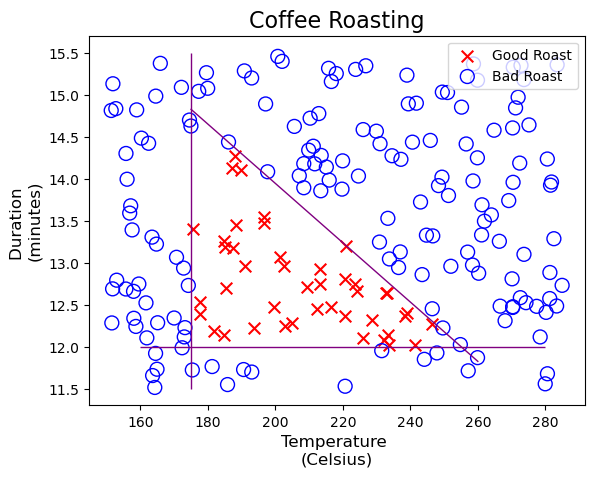

In [101]:
plot_dataSet(X_train, Y_train)

### Normalize Data

Fitting the weights to the data (back-propagation, covered in next week's lectures) will proceed more quickly if the data is normalized. This is the same procedure you used in Course 1 where features in the data are each normalized to have a similar range. The procedure below uses a Keras normalization layer. It has the following steps:

    create a "Normalization Layer". Note, as applied here, this is not a layer in your model.
    'adapt' the data. This learns the mean and variance of the data set and saves the values internally.
    normalize the data.

It is important to apply normalization to any future data that utilizes the learned model.


In [104]:
print(f"Temperature Max, Min pre normalization: {np.max(X_train[:,0]):0.2f}, {np.min(X_train[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X_train[:,1]):0.2f}, {np.min(X_train[:,1]):0.2f}")
norm = tf.keras.layers.Normalization(axis=-1)
norm.adapt(X_train)
Xn_train = norm(X_train)
print(f"Temperature Max, Min post normalization: {np.max(Xn_train[:,0]):0.2f}, {np.min(Xn_train[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn_train[:,1]):0.2f}, {np.min(Xn_train[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [105]:
Xt = np.tile(Xn_train, (1000, 1))
Yt = np.tile(Y_train, (1000, 1))
Xt.shape, Yt.shape

((200000, 2), (200000, 1))

## Tensorflow Model

In [107]:
model = Sequential([
    Input(shape=(2,)),
    Dense(units=3, activation="sigmoid", name="HLayer1"),
    Dense(units=1, activation="sigmoid", name="outputLayer")
])

<b>Note 1:</b> The tf.keras.Input(shape=(2,)), specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point. This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the model.fit statement.<br>
<b>Note 2:</b> Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab

In [109]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HLayer1 (Dense)             (None, 3)                 9         
                                                                 
 outputLayer (Dense)         (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [110]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


The following statements will be described in detail in Week2. For now:

    The model.compile statement defines a loss function and specifies a compile optimization.
    The model.fit statement runs gradient descent and fits the weights to the data.

In [115]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

model.fit(Xt, Yt, epochs=10)

Epoch 1/10
6250/6250 [==============================] - 18s 3ms/step - loss: 5.4899e-04 - accuracy: 1.0000
Epoch 2/10
6250/6250 [==============================] - 17s 3ms/step - loss: 3.9107e-04 - accuracy: 1.0000
Epoch 3/10
6250/6250 [==============================] - 17s 3ms/step - loss: 2.9777e-04 - accuracy: 1.0000
Epoch 4/10
6250/6250 [==============================] - 17s 3ms/step - loss: 2.2787e-04 - accuracy: 1.0000
Epoch 5/10
6250/6250 [==============================] - 16s 3ms/step - loss: 1.9961e-04 - accuracy: 1.0000
Epoch 6/10
6250/6250 [==============================] - 15s 2ms/step - loss: 1.5698e-04 - accuracy: 1.0000
Epoch 7/10
6250/6250 [==============================] - 15s 2ms/step - loss: 1.2286e-04 - accuracy: 1.0000
Epoch 8/10
6250/6250 [==============================] - 15s 2ms/step - loss: 9.5253e-05 - accuracy: 1.0000
Epoch 9/10
6250/6250 [==============================] - 16s 3ms/step - loss: 1.3872e-04 - accuracy: 1.0000
Epoch 10/10
6250/6250 [==============

### Epochs and batches

<pre>
In the compile statement above, the number of epochs was set to 10. This specifies that the entire data set should be applied during training 10 times. During training, you see output describing the progress of training that looks like this:

Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782

The first line, Epoch 1/10, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 200000 examples in our expanded data set or 6250 batches. The notation on the 2nd line 6250/6250 [==== is describing which batch has been executed.
</pre>


### Prediction

In [124]:
X_test = np.array([
    [185,12],  # postive example
    [259,11]     # negative example
])   
X_testn = norm(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 38ms/step
predictions = 
 [[9.9888343e-01]
 [1.5512171e-10]]


In [137]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


## Congratulations!

You have built a small neural network in Tensorflow. The network demonstrated the ability of neural networks to handle complex decisions by dividing the decisions between multiple units.
